In [1]:
import os
os.chdir(os.path.expanduser("~/ppi-core-genes/"))
from speos.utils.datahandlers import ResultsHandler
from speos.postprocessing.postprocessor import PostProcessor
from speos.utils.config import Config
from speos.visualization.settings import *

import numpy as np
import matplotlib as plt

# For plotting either lof or missense mutation intolerance, change the 'lof_or_missense' flag at the beginning of the next cell

cardiovascular_film 2023-01-27 12:01:55,293 [INFO] speos.postprocessing.postprocessor: Total of 3230 genes with significant LoF Intolerance, 2869 of them match with our translation table.
cardiovascular_film 2023-01-27 12:01:55,293 [INFO] speos.postprocessing.postprocessor: Found 129 LoF Intolerance genes among the 610 known positive genes (p: 2.21e-03, OR: 1.375), leaving 2740 in 16791 Unknowns
cardiovascular_film 2023-01-27 12:01:55,300 [INFO] speos.postprocessing.postprocessor: Fishers Exact Test for genes with significant LoF Intolerance among Predicted Genes. p: 6.93e-01, OR: 0.98
cardiovascular_film 2023-01-27 12:01:55,300 [INFO] speos.postprocessing.postprocessor: LoF Intolerance Confusion Matrix:
[[  634  2106]
 [ 3303 10748]]
cardiovascular_film 2023-01-27 12:01:55,309 [INFO] speos.postprocessing.postprocessor: ANOVA for LoF Z Value in Predicted Genes vs Non-Predicted Genes (Unknowns). p: 1.79e-12, F: 27.094
cardiovascular_film 2023-01-27 12:01:55,646 [INFO] speos.postprocessi

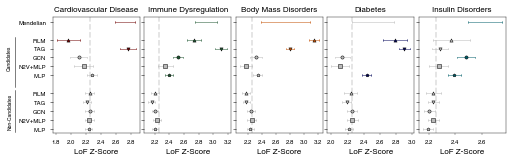

In [3]:
import pandas as pd
from speos.visualization.settings import *
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.lines import Line2D

lof_or_missense = 0

phenotypes = ["Cardiovascular Disease", "Immune Dysregulation", "Body Mass Disorders", "Diabetes", "Insulin Disorders"]
methods = ["film", "tag", "gcn", "n2vmlp", "mlp"]
pretty_methods = ["FiLM", "TAG", "GCN", "N2V+MLP", "MLP"]
groups = ["Noncandidate Gene", "Candidate Gene", "Mendelian"]
tick_size = small_font
label_size = medium_font

crimson = "#6f0000"
navy = "#02055a"
jungle = "#1e5631"
tan = "#c24e00"
petrol = "#005f6a"
grey = "#bbbbbb"
lightgrey = "#dddddd"
width_ratios= [10, 1]*2
marker_size=10
whiskers_length=0.1

fig, axes = plt.subplots(figsize=(full_width*cm,6*cm), ncols=5, sharey=True)
#axes = axes.flatten()
colors_ = [crimson, jungle, tan, navy, petrol]
markers = ["^", "v", "o", "s", "p"]

for phenotype, color_, ax in zip(phenotypes, colors_, axes):
    plot_df_means = pd.DataFrame(columns=pretty_methods, index=groups)
    plot_df_ci = pd.DataFrame(columns=pretty_methods, index=groups)
    dfs = []
    for method, pretty_method in zip(methods, pretty_methods):
        if method in ["gcn", "mlp", "n2vmlp"] and phenotype == "Immune Dysregulation":
            method += "_new"
    
        config_paths = {"Insulin Disorders": "configs/config_insulin_disorder_{}.yaml".format(method),
                        "Diabetes": "configs/config_diabetes_{}.yaml".format(method),
                        "Body Mass Disorders": "configs/config_bm_disorder_{}.yaml".format(method),
                        "Cardiovascular Disease": "configs/config_cardiovascular_{}.yaml".format(method),
                        "Immune Dysregulation": "configs/config_immune_dysregulation_{}.yaml".format(method)}

        if method == "film" and phenotype == "Immune Dysregulation":
            config_paths[phenotype] = "configs/config_immune_dysregulation_{}_forreal.yaml".format(method)

        config = Config()
        config.parse_yaml(config_paths[phenotype])

        pp = PostProcessor(config)

        import json

        outer_results_paths = {"Insulin Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}outer_results.json".format(method),
                        "Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}outer_results.json".format(method),
                        "Body Mass Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}outer_results.json".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}outer_results.json".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}outer_results.json".format(method)}

        results_files = {"Insulin Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}_outer_0_fold_1.tsv".format(method),
                        "Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}_outer_0_fold_1.tsv".format(method),
                        "Body Mass Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}_outer_0_fold_1.tsv".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}_outer_0_fold_1.tsv".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_outer_0_fold_1.tsv".format(method)}

        with open(outer_results_paths[phenotype], "r") as file:
            results = json.load(file)
        pp.outer_result = results
        pp.init_pp_table()
        lof, tukey = pp.lof_intolerance(results_files[phenotype], plot=False)
        df = pd.read_html(tukey[lof_or_missense].summary().as_html(), header=0, index_col=0)[0]
        df["p-adj"] = tukey[lof_or_missense].pvalues
        if getattr(tukey[lof_or_missense], 'halfwidths', None) is None:
            tukey[lof_or_missense]._simultaneous_ci()
        

        group_names = tukey[lof_or_missense].groupsunique
        means = tukey[lof_or_missense]._multicomp.groupstats.groupmean
        cis = tukey[lof_or_missense].halfwidths

        for group, mean, ci in zip(group_names, means, cis):
            plot_df_means.loc[group, pretty_method] = mean
            plot_df_ci.loc[group, pretty_method] = ci

        df.reset_index(inplace=True)
        df["Group Name"] = group_names
        df["Group N"] = [(np.asarray(tukey[lof_or_missense].groups) == group).sum() for group in group_names]
        df["Group Mean"] = means
        df["Lower 95% CI"] = np.asarray(means) - np.asarray(ci)
        df["Upper 95% CI"] = np.asarray(means) + np.asarray(ci)
        df[" "] = [" "] * len(df.index)
        df_columns = df.columns[-6:].tolist() + df.columns[:-6].tolist()
        df = df[df_columns]
        dfs.append(df)
    
    dfs_joined = pd.concat(dfs, keys=pretty_methods)
    dfs_joined.reset_index(inplace=True)
    dfs_joined.columns =  ["Method"] + dfs_joined.columns[1:].tolist()
    dfs_joined.drop("level_1", axis="columns", inplace=True)
    dfs_joined.to_csv("statistical_dump/{}_tukey_{}.tsv".format(phenotype, "lof" if lof_or_missense == 0 else "missense"), sep="\t", index=False)    

    max_comparisons = ((len(groups) - 1) * len(methods)) + 1 + 2

    ax.vlines(x=np.mean(tukey[lof_or_missense].data), ymin=0.5, ymax = max_comparisons + 0.5, linestyles=["--"], color=lightgrey, zorder=-10)
    ax.set_ylim((0.5, max_comparisons + 0.5))
    
    for group in groups[::-1]:
        for method, marker, df in zip(pretty_methods, markers, dfs):

            if group == "Noncandidate Gene":
                color = grey
            else:
                """
                nc_mean = plot_df_means.loc["Noncandidate Gene", method]
                nc_ci = plot_df_ci.loc["Noncandidate Gene", method]
                group_mean = plot_df_means.loc[group, method]
                group_ci = plot_df_ci.loc[group, method]
                big_enough = (nc_mean + nc_ci) < (group_mean - group_ci)
                small_enough = (nc_mean - nc_ci) > (group_mean + group_ci)
                
                if big_enough or small_enough:
                    color = color_

                """
                if df.loc[(df["group1"] == group) & (df["group2"] == "Noncandidate Gene"), "p-adj"].item() < 0.05:
                    color = color_
                else:
                    color = grey

            
            # draw Confidence Interval
            ax.plot((plot_df_means.loc[group, method] - plot_df_ci.loc[group, method], plot_df_means.loc[group, method] + plot_df_ci.loc[group, method]),
                    (max_comparisons, max_comparisons),
                     color=color,
                     linewidth=0.5)
            
            
            # draw Whiskers
            ax.plot((plot_df_means.loc[group, method] - plot_df_ci.loc[group, method], plot_df_means.loc[group, method] - plot_df_ci.loc[group, method]),
                    (max_comparisons + whiskers_length, max_comparisons - whiskers_length),
                     color=color,
                     linewidth=0.5)
            ax.plot((plot_df_means.loc[group, method] + plot_df_ci.loc[group, method], plot_df_means.loc[group, method] + plot_df_ci.loc[group, method]),
                    (max_comparisons + whiskers_length, max_comparisons - whiskers_length),
                     color=color,
                     linewidth=0.5)

            if group != "Mendelian":
                ax.scatter(plot_df_means.loc[group, method], max_comparisons, color=color, marker=marker, s=marker_size, linewidth=0.5, edgecolors='black', zorder=5)
            max_comparisons -= 1

            if group == "Mendelian":
                break

        max_comparisons -= 1
    
    label = ["LoF Z-Score", "Missense Z-Score"][lof_or_missense]

    ax.set_xlabel(label, size=label_size)
    ax.set_title(phenotype, size=label_size)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

ticks = [1,2,3,4,5,  7,8,9,10,11, 13]
names = (pretty_methods[::-1] * 2) + ["Mendelian"]

axes[0].set_yticks(ticks)
axes[0].set_yticklabels(names, size=label_size-2)

ticks = [9, 3]
names = ["Candidates", "Non-Candidates"]

if lof_or_missense == 1:
    x = -0.28
    offset = 0.05
else:
    x = 1.26
    offset = 0.1

axes[0].text(x=x-offset,y=ticks[0], s=names[0], rotation=90, va="center", size=small_font-1)
axes[0].text(x=x-offset,y=ticks[1], s=names[1], rotation=90, va="center", size=small_font-1)

line = Line2D((x, x), (0.7,5.3), color="black", linewidth=0.5)
line.set_clip_on(False)
axes[0].add_line(line)
line = Line2D((x, x), (5.7,11.3), color="black", linewidth=0.5)
line.set_clip_on(False)
axes[0].add_line(line)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
if lof_or_missense == 0:
    plt.savefig("lof_all.svg")
else:
    plt.savefig("missense_all.svg")